In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import os

import tqdm
import random
import warnings
import albumentations as A
warnings.filterwarnings('ignore')

In [1]:
! unzip -qq tree_primige.zip

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm

class Video2Class(Dataset):
    def __init__(self, concrete_folder, priming_folder,
                 brick_folder, tree_folder, test=False,
                 test_size=0.2, transform=None):

        super(Video2Class, self).__init__()
        self.flag = True
        self.concrete_file_names = [f for f in os.listdir(concrete_folder) if f.endswith('.mp4')]
        self.priming_file_names = [f for f in os.listdir(priming_folder) if f.endswith('.mp4')]
        self.tree_file_names = [f for f in os.listdir(tree_folder) if f.endswith('.mp4')]
        self.brick_file_names = [f for f in os.listdir(brick_folder) if f.endswith('.mp4')]
        # print(self.concrete_file_names[-1], self.concrete_file_names[-2])

        # self.concrete_file_names = self.concrete_file_names[:10]
        # self.priming_file_names = self.priming_file_names[:10]
        # self.tree_file_names = self.tree_file_names[:10]
        # self.brick_file_names = self.brick_file_names[:10]

        self.data = []
        # print(self.concrete_file_names, self.priming_file_names, self.tree_file_names, self.brick_file_names)
        self.trans  = transforms.Compose([
            transforms.Resize(448),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.weather_transforms = [A.Compose([A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1)],),
                                   A.Compose([A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)],),
                                   A.Compose([A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=1)],),
                                   A.Compose([A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.1, p=1)],)
                                   ]
        self.give_data(concrete_folder, self.concrete_file_names, 0)
        self.give_data(priming_folder, self.priming_file_names, 1)
        self.give_data(tree_folder, self.tree_file_names, 2)
        self.give_data(brick_folder, self.brick_file_names, 3)

        
        
    def give_data(self, folder_name, file_list, class_id):
        random_rotation = transforms.RandomRotation(degrees=(-45, 45))
        brightness_transform = transforms.ColorJitter(brightness=1.8)
        for filename in tqdm(file_list):
            name = os.path.join(folder_name, filename)
            video_file = []

            start_time = 119  # начальное время (2 минуты)
            end_time = 135    # конечное время (3 минуты)

            # Открываем исходное видеофайл
            video = cv2.VideoCapture(name)

            # Вычисляем FPS (кадры в секунду)
            fps = 12

            # Вычисляем количество кадров, которые нужно пропустить
            start_frame = int(start_time * fps)
            end_frame = int(end_time * fps)

            # Устанавливаем текущий кадр на начальный
            video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            # Обрабатываем и отображаем кадры в заданном временном промежутке
            for frame_number in range(start_frame, end_frame):
                ret, frame = video.read()
                if not ret:
                    break
                video_file.append(frame)

            # Закрываем видеопоток
            video.release()
            first = int(16 * 12) - 1
            second = first - 12 * 3
            third = second - 12 * 6
            fourth = third - 12 * 9
            fivth = fourth - 12 * 12

            p = random.randint(0, 1)
            q = random.randint(0, 3)
            k = random.randint(0, 3)
            
            wt_tr = self.weather_transforms[k]
            w1, w2, w3, w4, w5 = wt_tr(image=video_file[fivth]), wt_tr(image=video_file[fourth]), wt_tr(image=video_file[third]), wt_tr(image=video_file[second]), wt_tr(image=video_file[first])
            w = torch.from_numpy(np.stack([w1['image'], w2['image'], w3['image'], w4['image'], w5['image']])).permute(0, 3, 1, 2) / 255.
            self.data.append((self.trans(w), class_id))
            
            if p == 1:
                self.blur_photo(video_file[fivth], video_file[fourth], video_file[third], video_file[second], video_file[first], class_id)
                
            video_itg = torch.from_numpy(np.stack([video_file[fivth], video_file[fourth], video_file[third], video_file[second], video_file[first]])).permute(0, 3, 1, 2) / 255.
            video_rot = random_rotation(video_itg)
            
            if q == 0:
                video_light = brightness_transform(video_itg)
                video_light = self.trans(video_light)
                self.data.append((video_light, class_id))
            

            video_rot = self.trans(video_rot)
            video_itg = self.trans(video_itg)
            if self.flag:
                print(video_itg.shape)
                self.flag = False
            self.data.append((video_itg, class_id))
            self.data.append((video_rot, class_id))

    def blur_photo(self, img1, img2, img3, img4, img5, class_id):
        blurred_image1 = cv2.GaussianBlur(img1, (21, 21), 0) 
        blurred_image2 = cv2.GaussianBlur(img2, (21, 21), 0) 
        blurred_image3 = cv2.GaussianBlur(img3, (21, 21), 0) 
        blurred_image4 = cv2.GaussianBlur(img4, (21, 21), 0) 
        blurred_image5 = cv2.GaussianBlur(img5, (21, 21), 0) 
        blurred_itg = torch.from_numpy(np.stack([blurred_image1, blurred_image2, blurred_image3, blurred_image4, blurred_image5])).permute(0, 3, 1, 2) / 255
        blurred_itg = self.trans(blurred_itg)
        self.data.append((blurred_itg, class_id))

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        return self.data[idx]


In [4]:
traindataset = Video2Class(concrete_folder='train_folder/Бетон', priming_folder='train_folder/Грунт', brick_folder='train_folder/Кирпич', tree_folder='train_folder/Дерево')

  0%|          | 0/208 [00:00<?, ?it/s]

torch.Size([5, 3, 224, 224])


  0%|          | 0/223 [00:00<?, ?it/s]

IndexError: list index out of range

In [7]:
testdataset = Video2Class(concrete_folder='test_folder/test_concrete', priming_folder='test_folder/test_primige', brick_folder='test_folder/test_brick', tree_folder='test_folder/test_tree')

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([5, 3, 224, 224])


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
len(testdataset), #len(traindataset)

(305,)

[43, 123, 205, 247, 301, 28, 225, 266]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

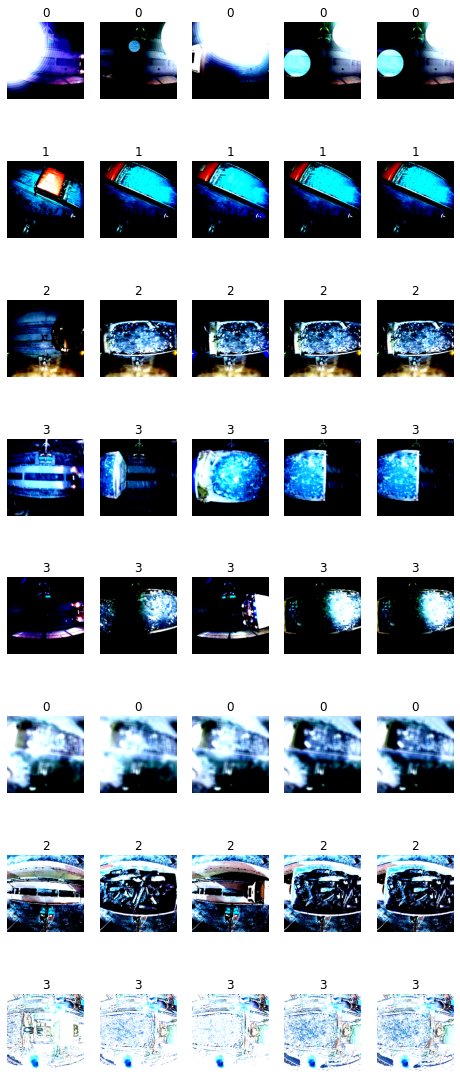

In [10]:
random_indices = random.sample(range(305), 8)
print(random_indices)
fig, ax = plt.subplots(8, 5, figsize=(8, 20))
for i, idx in enumerate(random_indices):
    img, cl = testdataset[idx]
    img1, img2, img3, img4, img5 = img[0], img[1], img[2], img[3], img[4] 
    img1 = img1.permute(1, 2, 0).numpy()
    img2 = img2.permute(1, 2, 0).numpy()
    img3 = img3.permute(1, 2, 0).numpy()
    img4 = img4.permute(1, 2, 0).numpy()
    img5 = img5.permute(1, 2, 0).numpy()
    ax[i, 0].imshow(img1)
    ax[i, 0].set_title(str(cl))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(img2)
    ax[i, 1].set_title(str(cl))
    ax[i, 1].axis('off')
    ax[i, 2].imshow(img3)
    ax[i, 2].set_title(str(cl))
    ax[i, 2].axis('off')
    ax[i, 3].imshow(img4)
    ax[i, 3].set_title(str(cl))
    ax[i, 3].axis('off')
    ax[i, 4].imshow(img4)
    ax[i, 4].set_title(str(cl))
    ax[i, 4].axis('off')
    
    


In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(traindataset, batch_size=32, shuffle=True)
test_loader = DataLoader(testdataset, batch_size=32, shuffle=False)


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)       
        self.fc = nn.Linear(28800, num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        # out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [16]:
from torchvision import models

class CustomResnet(nn.Module):
    def __init__(self, num_freeze_layers=0):
        super(CustomResnet, self).__init__()
        self.res = models.resnet18(pretrained=True)
        
        for i, (name, layer) in enumerate(self.res.named_children()):
            if i < num_freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False
        
        self.res.fc = nn.Sequential(
            nn.Linear(512, 4)
        )
    
    def forward(self, x):
        return self.res(x)

class CustomSqueezenet(nn.Module):
    def __init__(self, num_freeze_layers=0):
        super(CustomSqueezenet, self).__init__()
        self.res = models.squeezenet1_0(pretrained=True)
        
        for i, (name, layer) in enumerate(self.res.named_children()):
            if i < num_freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False
        
        self.res.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
    
    def forward(self, x):
        return self.res(x)
    
    
class CustomMobile(nn.Module):
    def __init__(self, num_freeze_layers=0):
        super(CustomMobile, self).__init__()
        self.res = models.mobilenet_v2(pretrained=True)
        
        for i, (name, layer) in enumerate(self.res.named_children()):
            if i < num_freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False
        
        self.res.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1280, 4)
        )
    
    def forward(self, x):
        return self.res(x)

class Wastes_Classifier(nn.Module):
    def __init__(self):

        super(Wastes_Classifier, self).__init__()

        self.reses = nn.ModuleList()
        for i in range(5):
            self.reses.append(ResNet(ResidualBlock, 4))
    def forward(self, img):
        out = []
        for i, layer in enumerate(self.reses):
            out.append(layer(img[:,i,:,:,:]))
        out = torch.cat(out, dim=1)

        return self.classifier(out)
model = Wastes_Classifier()
model.to(device)

Wastes_Classifier(
  (reses): ModuleList(
    (0-4): 5 x ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (layer1): Sequential(
        (0): ResidualBlock(
          (left): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (shortcut): Sequential()
        )
        (1): ResidualBlock(
          (left): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
model(testdata[0].unsqueeze(0).to(device).to(torch,

In [40]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)

In [41]:
def train(model, loss_fn, optimizer, n_epoch=100):
    save_path = 'model_folder'
    train_loss_list = []
    test_loss_list = []

    for epoch in tqdm(range(n_epoch)):
        model.train(True)
        train_loss = 0
        train_acc = 0

        test_loss = 0
        test_acc = 0

        num_correct_test = 0
        num_correct_train = 0


        for i, batch in enumerate(train_loader):

            optimizer.zero_grad()

            X_batch, y_batch = batch[0].to(torch.float32).to(device), batch[1].to(device)

            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            y_pred = torch.argmax(logits, dim=1)

            num_correct_train += torch.sum(y_pred.cpu() == y_batch.cpu())

        train_acc = num_correct_train / len(traindataset)
        train_loss = train_loss / len(train_loader)


        if i <= 50:
            scheduler.step()
        train_loss_list.append(train_loss)


        model.eval()
        with torch.no_grad():
            for batch in (test_loader):



                X_batch, y_batch = batch[0].to(torch.float32).to(device), batch[1].to(device)

                y_pred = model(X_batch.to(device))
                test_loss += loss_fn(y_pred, y_batch).item()

                y_pred = torch.argmax(y_pred, dim=1)

                num_correct_test += torch.sum(y_pred.cpu() == y_batch.cpu())


            test_loss_list.append(test_loss / len(test_loader))
            test_acc = num_correct_test / len(testdataset)



        if epoch % 5 == 0:

            print(f'Train loss: {train_loss}||Test loss: {test_loss_list[-1]}')
            print(f'Train acc: {train_acc}||Test acc: {test_acc}')
            if epoch != 0:
                fig, ax = plt.subplots(1, 2, figsize=(10, 3))
                ax[0].plot(train_loss_list)
                ax[0].set_title('Тренировачная кривая обучения')
                ax[1].plot(test_loss_list)
                ax[1].set_title('Тестовая кривая обучения')
                plt.show()
            if epoch % 100 == 0:
                model_save_path = os.path.join(save_path, f'model_epoch_{epoch}.pt')
                torch.save(model.state_dict(), model_save_path)
    return model


  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss: 0.657391840616862||Test loss: 1.7995983213186264
Train acc: 0.757908046245575||Test acc: 0.6033057570457458
Train loss: 0.1891169601182143||Test loss: 1.650086459965678
Train acc: 0.9548713564872742||Test acc: 0.6652892827987671


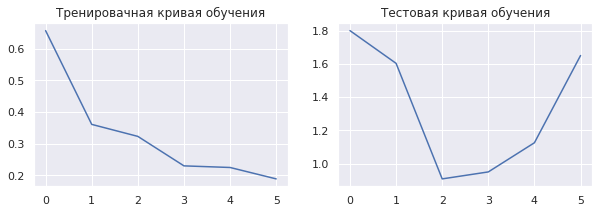

Train loss: 0.1460455953453978||Test loss: 1.2004052549600601
Train acc: 0.9578236937522888||Test acc: 0.6652892827987671


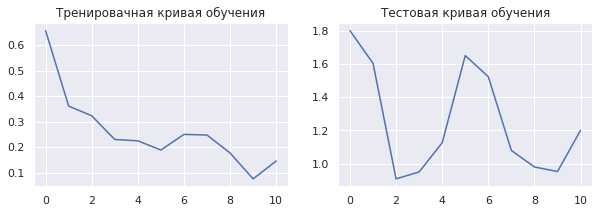

Train loss: 0.04223637771288243||Test loss: 1.1725249402225018
Train acc: 0.9865036010742188||Test acc: 0.6942148804664612


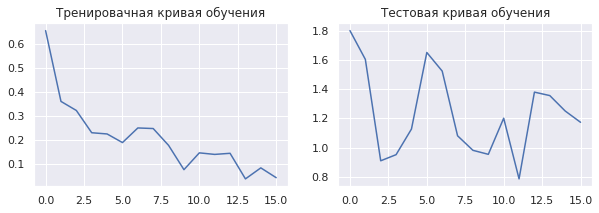

Train loss: 0.03877445938065648||Test loss: 1.0995660051703453
Train acc: 0.9890341758728027||Test acc: 0.7396694421768188


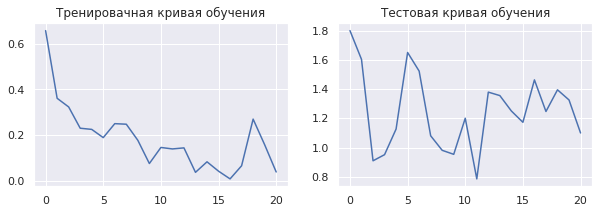

Train loss: 0.02383135766411821||Test loss: 1.2567470958456397
Train acc: 0.9940953254699707||Test acc: 0.7148760557174683


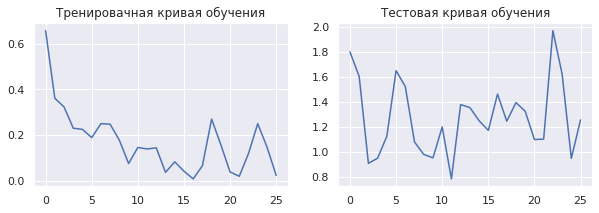

KeyboardInterrupt: 

In [42]:
model = train(model, loss_fn, optimizer, 1000)

In [43]:
model.eval()
from sklearn.metrics import confusion_matrix

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in testdataset:
        inputs = inputs.unsqueeze(0).to(device).to(torch.float32)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        all_labels.append(labels)
        all_predictions.append(predictions.tolist())

conf_matrix = confusion_matrix(all_labels, all_predictions)


In [139]:
for i in range(len(all_labels)):
    if (all_labels[i] == all_predictions[i]):
        print(i)


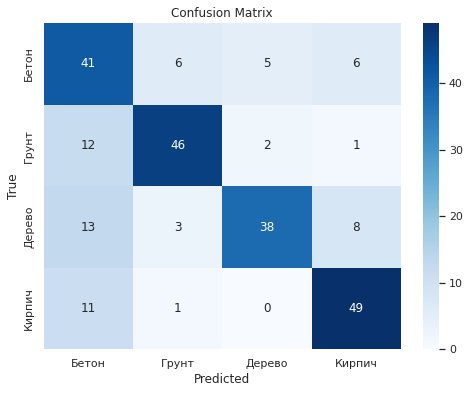

In [44]:
import seaborn as sns
sns.set()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Бетон', 'Грунт', 'Дерево', 'Кирпич'],
            yticklabels=['Бетон', 'Грунт', 'Дерево', 'Кирпич'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [131]:
video_file = []

start_time = 119  # начальное время (2 минуты)
end_time = 135    # конечное время (3 минуты)
name = "C565PC799_08_11_2023 10_06_27.mp4"
# Открываем исходное видеофайл
video = cv2.VideoCapture(name)

# Вычисляем FPS (кадры в секунду)
fps = 12

# Вычисляем количество кадров, которые нужно пропустить
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Устанавливаем текущий кадр на начальный
video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Обрабатываем и отображаем кадры в заданном временном промежутке
for frame_number in range(start_frame, end_frame):
    ret, frame = video.read()
    if not ret:
        break
    video_file.append(frame / 255)

# Закрываем видеопоток
video.release()
first = int(16 * 12) - 1
second = first - 12 * 5
third = second - 12 * 10

In [132]:
video_itg = torch.from_numpy(np.stack([video_file[third], video_file[second], video_file[first]])).permute(0, 3, 1, 2)
trans = transforms.Compose([
            transforms.Resize(448),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
video_itg = trans(video_itg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

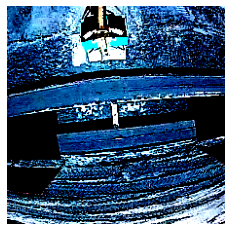

In [121]:
img1, img2, img3 = video_itg[0], video_itg[2], video_itg[1]
img1 = img1.permute(1, 2, 0).numpy()
img2 = img2.permute(1, 2, 0).numpy()
img3 = img3.permute(1, 2, 0).numpy()
plt.imshow(img3)
plt.axis('off')

In [133]:
with torch.inference_mode():
    logits = model(video_itg.unsqueeze(0).to(device).to(torch.float32))

In [134]:
nn.functional.softmax(logits)

tensor([[9.9999e-01, 6.7701e-10, 5.5376e-06, 1.4139e-10]], device='cuda:0')

In [146]:
model_save_path = os.path.join('model_folder', f'model96.pt')
torch.save(model.state_dict(), model_save_path)